# Estimating Canopy Cover from Images

1. Get the image with `imageio`.
2. Crop the image so that it is circle,
   the diameter of which is the same size as the smallest dimension of the image.
   Then it doesn't matter if the orientation of the camera changes.
   Two picture taken from the same position should have the same result,
   even if the second picture is taken at 90 degrees to the first.
2. Convert to grey scale with `skimage`.
3. Don't blur the image because we aren't trying to detect edges or features.
3. Take a look at the histogram and guess the threshold.
4. Find the boundary between light and dark
   (Otsu's method <https://en.wikipedia.org/wiki/Otsu%27s_method> in `skimage`).
5. Set everything above and below the boundary to either black or white (binary mask).
6. Count the percentage of pixels that are black.

In [1]:
%matplotlib widget

import imageio.v3 as iio
import numpy
import skimage
from matplotlib import pyplot
from skimage import draw

# Get the image

Using `imageio.v3.imread` because I hear tell that the `io.imread` in `skimage`
can alter the image when it is read.
Besides the `imageio.v3.imread` has more options.

In [2]:
"""Look at the images"""
CANOPY_IMAGE = iio.imread(
    uri="../data/raw/2019-06/P6200003.JPG"
)

## Circular Mask

Get the size of the image and create a circular mask.
Take a look at the mask to make sure it looks plausible.

(np.float64(-0.5), np.float64(1919.5), np.float64(1279.5), np.float64(-0.5))

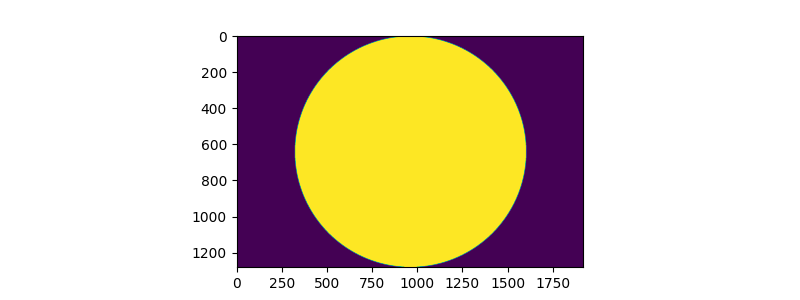

In [3]:
height, width = CANOPY_IMAGE.shape[:2]
diameter = min(height, width)
radius = diameter // 2
center_y, center_x = height // 2, width // 2
# Create a mask with a circle
mask = numpy.zeros((height, width), dtype=bool)
rr, cc = draw.disk((center_y, center_x), radius, shape=mask.shape)
mask[rr, cc] = True

figure, axes = pyplot.subplots(figsize=(8,3))
axes.imshow(mask)
axes.axis('on')

### Count the Mask Pixels

The number of pixels in the mask.

In [4]:
mask_pixels = numpy.sum(mask)
print(mask_pixels)

1286717


## Convert to Gray Scale

And take a look.

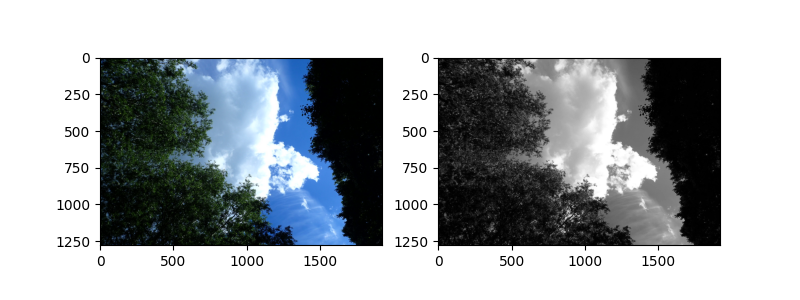

In [5]:
CANOPY_IMAGE_IN_GRAYSCALE = skimage.color.rgb2gray(CANOPY_IMAGE)

fig, axes = pyplot.subplots(1, 2, figsize=(8, 3))  # Adjust DPI if needed
axes[0].imshow(CANOPY_IMAGE)
axes[0].axis('on')

axes[1].imshow(CANOPY_IMAGE_IN_GRAYSCALE, cmap=pyplot.cm.gray)
axes[1].axis('on')

pyplot.show()

For reference these are the available `cmap` options.

In [6]:
"""Show the color maps"""
TRUNCATED_LIST_OF_COLOR_MAPS = pyplot.cm._colormaps()[:9]
print(TRUNCATED_LIST_OF_COLOR_MAPS)

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues']


Look at the histogram of the luminance distribution.

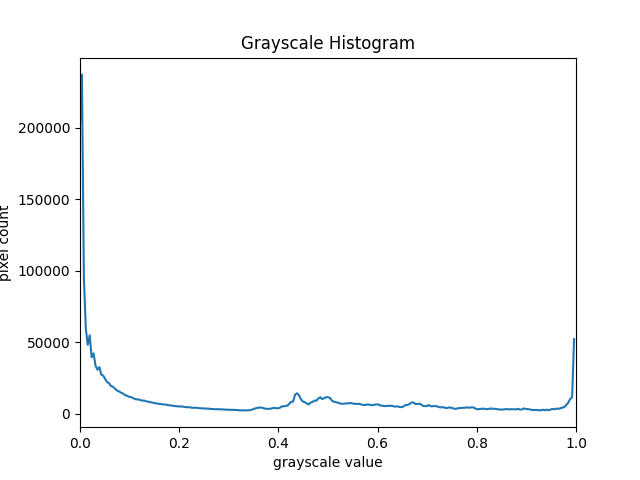

In [7]:
"""Look at the histogram."""
histogram, bin_edges = numpy.histogram(CANOPY_IMAGE_IN_GRAYSCALE, bins=256, range=(0, 1))

fig, ax = pyplot.subplots()
ax.set_title("Grayscale Histogram")
ax.set_xlabel("grayscale value")
ax.set_ylabel("pixel count")
ax.set_xlim([0.0, 1.0])

ax.plot(bin_edges[:-1], histogram)

Create a binary mask with the threshold of 0.5 and take a look at ti.

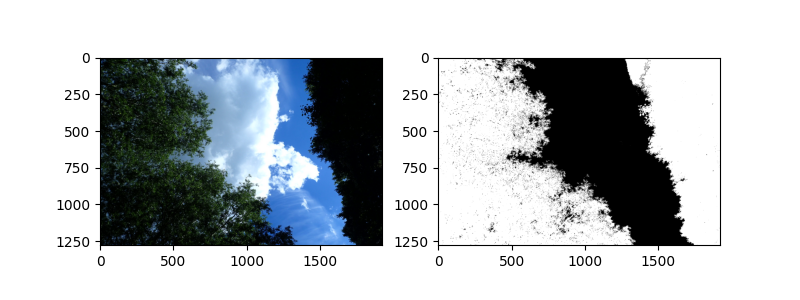

In [8]:
"""Create the binary mask"""
THRESHOLD = 0.4
BINARY_MASK = CANOPY_IMAGE_IN_GRAYSCALE < THRESHOLD

fig, axes = pyplot.subplots(1, 2, figsize=(8, 3))  # Adjust DPI if needed
axes[0].imshow(CANOPY_IMAGE)
axes[0].axis('on')

axes[1].imshow(BINARY_MASK, cmap=pyplot.cm.gray)
axes[1].axis('on')

pyplot.show()

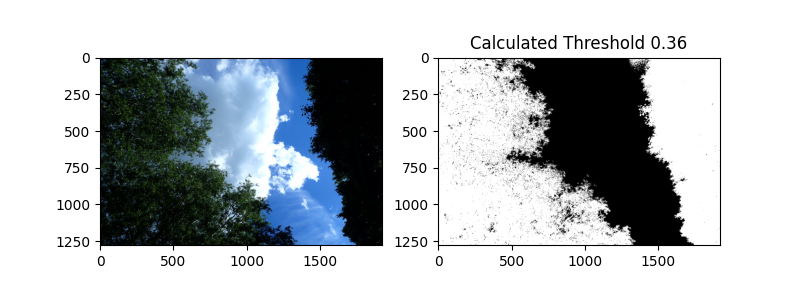

In [9]:
"""Determine the threshold using Otsu's method"""

calculated_threshold = skimage.filters.threshold_otsu(CANOPY_IMAGE_IN_GRAYSCALE)
calculated_threshold = round(calculated_threshold, 2)
BINARY_MASK = CANOPY_IMAGE_IN_GRAYSCALE < calculated_threshold

fig, axes = pyplot.subplots(1, 2, figsize=(8, 3))  # Adjust DPI if needed
axes[0].imshow(CANOPY_IMAGE)
axes[0].axis('on')

axes[1].set_title(f'Calculated Threshold {calculated_threshold}')
axes[1].imshow(BINARY_MASK, cmap=pyplot.cm.gray)
axes[1].axis('on')

pyplot.show()

## Canopy Pixels in the Mask

Get the number of pixels with canopy cover,
in the masked area.

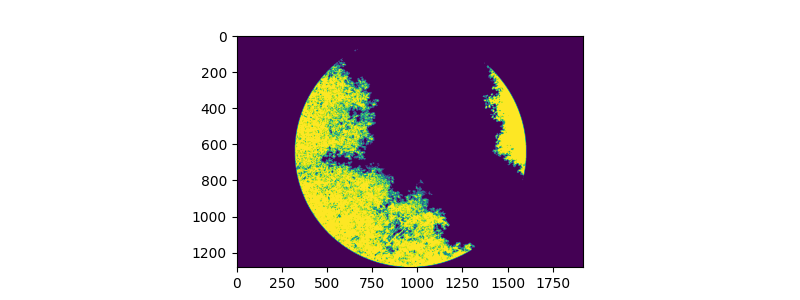

In [10]:
""""""
MASKED_IMAGE = mask * BINARY_MASK

figure, axes = pyplot.subplots(figsize=(8,3))
axes.imshow(MASKED_IMAGE)

Now we can count the 1s in the image.

In [13]:
"""Actually calculate the canopy cover."""
CANOPY_PIXELS_IN_MASK = numpy.sum(MASKED_IMAGE)
print(f"Total pixels of canopy {CANOPY_PIXELS_IN_MASK:,}")

percentage_canopy_cover = CANOPY_PIXELS_IN_MASK/mask_pixels

print(f"Percentage canopy cover {percentage_canopy_cover:.2f}")

Total pixels of canopy 487,448
Percentage canopy cover 0.38
